A simple hierarchical IRT model.

In [30]:
import pangolin
from pangolin import interface as pi
import numpy as np
from matplotlib import pyplot as plt

# params
num_students = 20
num_items = 20
num_obs = 3 * num_students
latent_dims = 2

# fixed observation pattern
students = np.random.randint(0, num_students, num_obs)
items = np.random.randint(0, num_obs, num_obs)

# model
mu_students = pi.multi_normal(np.zeros(latent_dims), np.eye(latent_dims))
sigma_students = pi.wishart(latent_dims+1, np.eye(latent_dims))
student_feats = pi.vmap(pi.multi_normal, None, num_students)(mu_students, sigma_students)

mu_items = pi.multi_normal(np.zeros(latent_dims), np.eye(latent_dims))
sigma_items = pi.wishart(latent_dims+1, np.eye(latent_dims))
item_feats = pi.vmap(pi.multi_normal, None, num_items)(mu_items, sigma_items)

scores = pi.sum(student_feats[students, :] * item_feats[items, :], axis=1)
y = pi.vmap(pi.bernoulli_logit)(scores)

In [31]:
# check sizes are all exactly what we expect
assert mu_students.shape == (latent_dims,)
assert sigma_students.shape == (latent_dims, latent_dims)
assert student_feats.shape == (num_students, latent_dims)

assert mu_items.shape == (latent_dims,)
assert sigma_items.shape == (latent_dims, latent_dims)
assert item_feats.shape == (num_items, latent_dims)

assert scores.shape == (num_obs,)
assert y.shape == (num_obs,)

In [32]:
# group latent variables for convenience
z = dict(mu_students=mu_students,
        sigma_students=sigma_students,
        student_feats=student_feats,
        mu_items=mu_items,
        sigma_items=sigma_items,
        item_feats=item_feats)

In [33]:
# print IR for fun
pi.print_upstream(y=y, scores=scores, **z)

shape   | statement
------- | ---------
(2,)    | a = [0. 0.]
(2, 2)  | b = [[1. 0.] [0. 1.]]
(2,)    | mu_items ~ multi_normal(a,b)
()      | c = 3
(2, 2)  | d = [[1. 0.] [0. 1.]]
(2, 2)  | sigma_items ~ wishart(c,d)
(20, 2) | item_feats ~ vmap(multi_normal, (None, None), 20)(mu_items,sigma_items)
(2,)    | e = [0. 0.]
(2, 2)  | f = [[1. 0.] [0. 1.]]
(2,)    | mu_students ~ multi_normal(e,f)
()      | g = 3
(2, 2)  | h = [[1. 0.] [0. 1.]]
(2, 2)  | sigma_students ~ wishart(g,h)
(20, 2) | student_feats ~ vmap(multi_normal, (None, None), 20)(mu_students,sigma_students)
(60,)   | i = [ 9 11 ... 2 14]
(2,)    | j = [0 1]
(60, 2) | k = simple_index(student_feats,i,j)
(60,)   | l = [ 1 33 ... 58 34]
(2,)    | m = [0 1]
(60, 2) | n = simple_index(item_feats,l,m)
(60, 2) | o = vmap(vmap(mul, (0, 0), 2), (0, 0), 60)(k,n)
(60,)   | scores = sum(axis=1)(o)
(60,)   | y ~ vmap(bernoulli_logit, (0,), 60)(scores)


In [34]:
# synthetic data and corresponding true params
[y_obs, z_true] = pangolin.jax_backend.ancestor_sample([y, z])

In [35]:
z_samps = pangolin.blackjax.sample(z, y, y_obs)

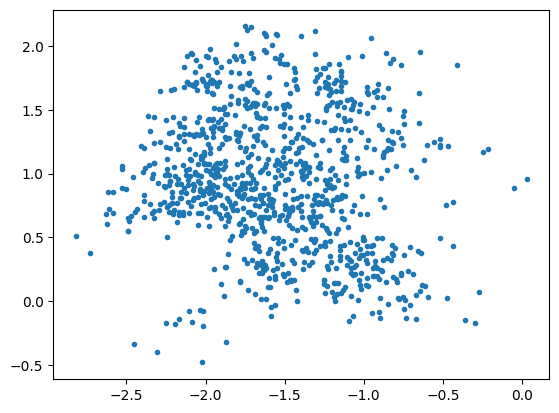

In [38]:
plt.plot(*z_samps['mu_students'].T,'.');

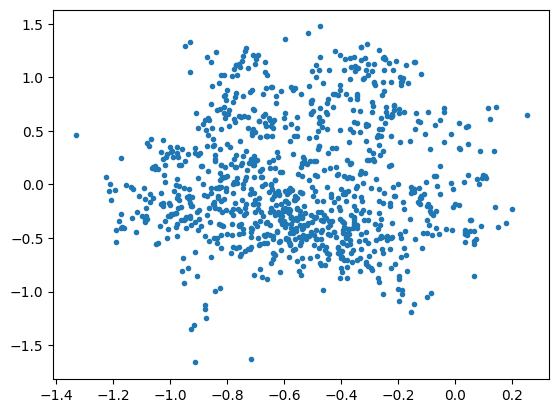

In [39]:
plt.plot(*z_samps['mu_items'].T,'.');

In [ ]:
# get good-old jax log-prob function

log_prob = pangolin.jax_backend.ancestor_log_prob(z)
z_init = {name: np.eye(rv.shape[0]) if isinstance(rv.op, pangolin.ir.Wishart)
          else np.zeros(rv.shape) for name, rv in z.items()}
log_prob(z_init)

Array(-84.252884, dtype=float32)